**Import Necessary Libraries**

In [1]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

**Checking for GPU's avaiable**

In [2]:
import tensorflow as tf

# List available GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPUs available:")
    for gpu in gpus:
        print(f" - {gpu.name}")
else:
    print("No GPUs available.")

GPUs available:
 - /physical_device:GPU:0


In [3]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
!unzip -q kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   298M      0  0:00:02  0:00:02 --:--:--  298M


In [4]:
!ls

 CDLA-Permissive-2.0.pdf   kagglecatsanddogs_5340.zip   PetImages  'readme[1].txt'   sample_data


In [6]:
!ls PetImages

Cat  Dog


**Remove Corrupted Images**

In [7]:
num_skipped = 0
directory = "Dataset"
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join(directory,"PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 1590 images.


**Preparing the Dataset for Training and Validation**

In [8]:
image_size = (180, 180)
batch_size = 50

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "Dataset/PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


**Visualizing Some Training Images**

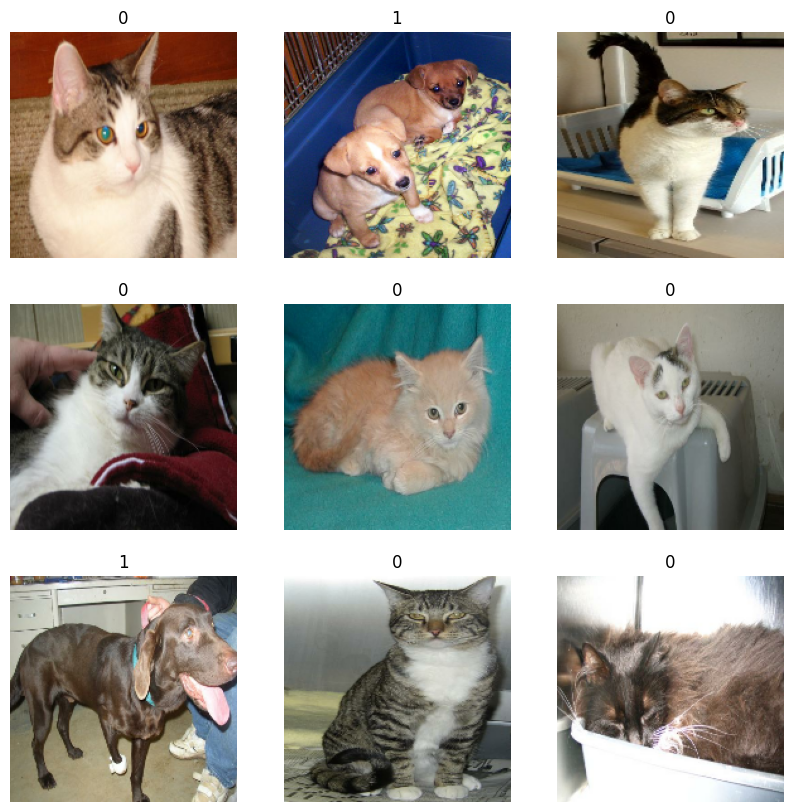

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [10]:
print(images.shape)

(50, 180, 180, 3)


**Data Augmentation for Training**

In [11]:
# Define data augmentation layers
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2)
]

# Data augmentation function
def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

**Visualizing Augmented Images**

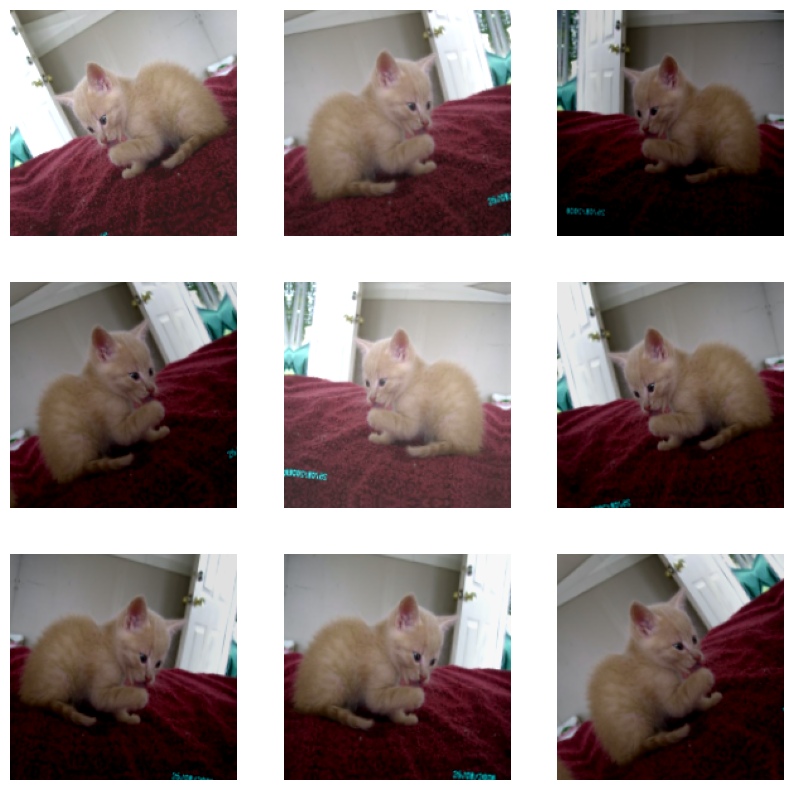

In [21]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

**Apply Data Augmentation to Training Data**

In [22]:
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

**Building the Model**

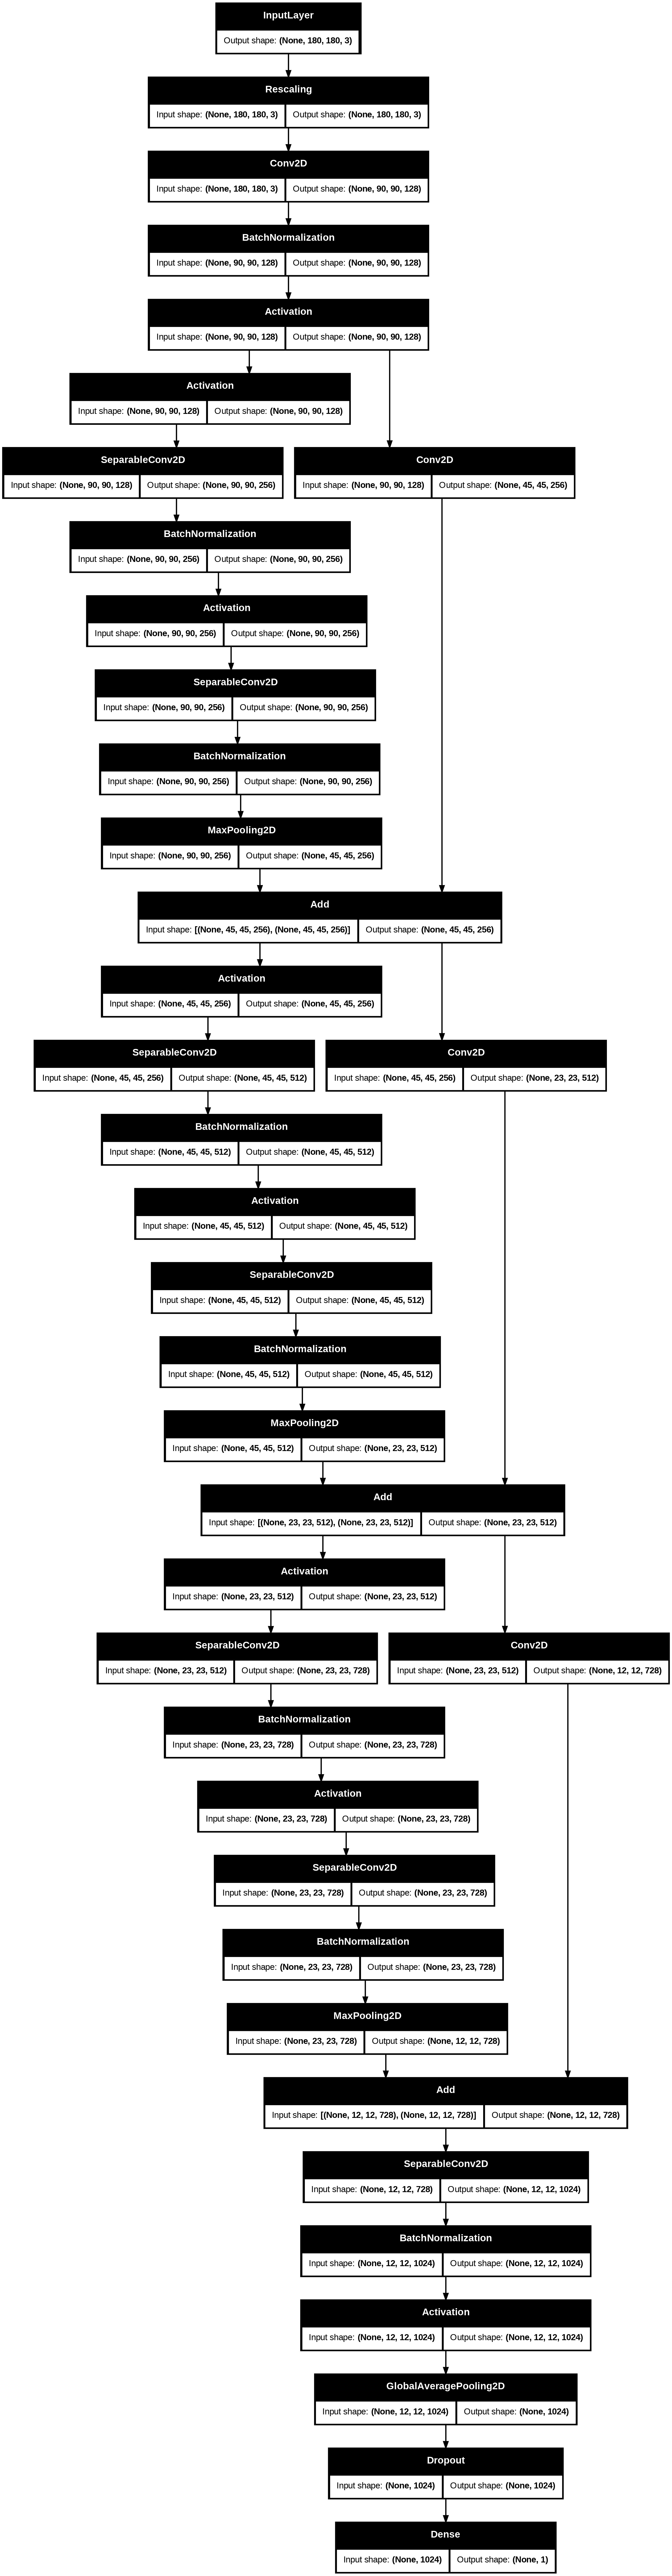

In [23]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)

model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True) # visualizing the architecture

**Model Compilation and Training**

In [24]:
epochs = 20

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]

model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)

model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 290s 633ms/step - acc: 0.6266 - loss: 0.6363 - val_acc: 0.4957 - val_loss: 0.7005
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 272s 724ms/step - acc: 0.7590 - loss: 0.4698 - val_acc: 0.5846 - val_loss: 0.6840
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 192s 511ms/step - acc: 0.8258 - loss: 0.3742 - val_acc: 0.8041 - val_loss: 0.3713
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 193s 488ms/step - acc: 0.8561 - loss: 0.3117 - val_acc: 0.8014 - val_loss: 0.3544
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 202s 489ms/step - acc: 0.8762 - loss: 0.2788 - val_acc: 0.8328 - val_loss: 0.5230
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 212s 516ms/step - acc: 0.8887 - loss: 0.2512 - val_acc: 0.8859 - val_loss: 0.2445
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 184s 490ms/step - acc: 0.9093 - loss: 0.2117 - val_acc: 0.9058 - val_loss: 0.1976
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 183s 487ms/step - acc: 0.9131 - loss: 0.1986 - val_acc: 0.9233 - val_loss: 0.1893
Epoch 9/20
375/375 ━━━━━

**Precision and Recalls**

147/147 ━━━━━━━━━━━━━━━━━━━━ 16s 99ms/step
Precision: 0.9665
Recall: 0.9297


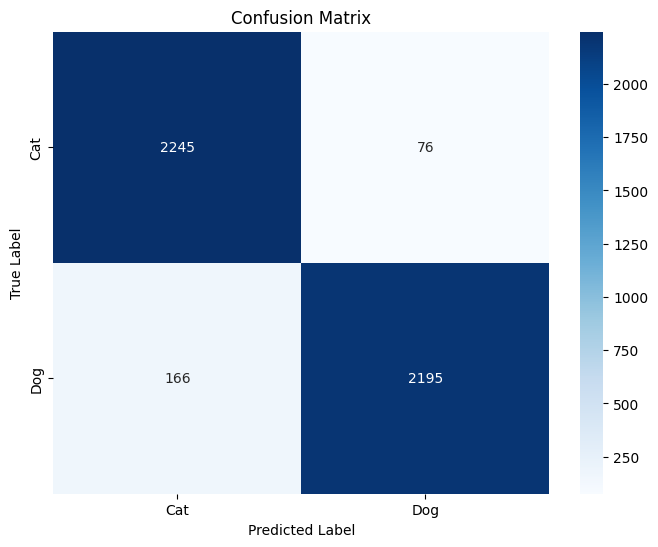

In [25]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the trained model (if not already loaded)
model = tf.keras.models.load_model("save_at_20.keras")

# Generate predictions on validation dataset
val_images, val_labels = [], []

for images, labels in val_ds:
    val_images.append(images.numpy())
    val_labels.append(labels.numpy())

val_images = np.concatenate(val_images)
val_labels = np.concatenate(val_labels)

# Predict probabilities and then convert them to binary predictions
predictions = model.predict(val_images)
predicted_labels = np.where(predictions > 0.5, 1, 0)

# Calculate Precision & Recall
precision = precision_score(val_labels, predicted_labels)
recall = recall_score(val_labels, predicted_labels)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

# Generate the confusion matrix
conf_matrix = confusion_matrix(val_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Cat", "Dog"], yticklabels=["Cat", "Dog"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

**CSV file for Test Results**

In [26]:
import pandas as pd

# If you have filenames, otherwise create dummy names
image_names = [f"image_{i}.jpg" for i in range(len(val_images))]

# Convert predictions to scores (probabilities)
scores = predictions.flatten()

# Create a DataFrame with the results
results_df = pd.DataFrame({
    "image_name": image_names,
    "true_label": val_labels,
    "predicted_label": predicted_labels.flatten(),
    "score": scores
})

# Save to CSV
results_df.to_csv("test_results.csv", index=False)

print("CSV file created successfully.")

CSV file created successfully.


In [27]:
model.save("cat_dog_model.h5")  # Save the final trained model

In [28]:
from google.colab import files
files.download("cat_dog_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>